# **COVID DETECTION USING SUPERVISED LEARNING ALGORITHMS**

## **Download and unzip data**

In [198]:
# dataset is stored in gdrive to avoid re-uploading the heavy file multiple times 
!pip install --upgrade --no-cache-dir gdown

### *Automating the process of finding ID from the given link*

In [199]:
link = 'https://drive.google.com/u/0/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou&export=download'
lst = link.split('/')
lst.pop(3)
lst.pop(3)
url = "/".join(lst).split('&')[0]

In [200]:
url

'https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou'

### *Giving the ID of the dataset to download zip file and then extracting it*

In [201]:
import gdown
output = "COVID-19_Radiography_Dataset.zip"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
To: /content/COVID-19_Radiography_Dataset.zip
100%|██████████| 780M/780M [00:04<00:00, 190MB/s]


'COVID-19_Radiography_Dataset.zip'

In [202]:
import zipfile
with zipfile.ZipFile('/content/COVID-19_Radiography_Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')
!rm ./COVID-19_Radiography_Dataset.zip

## **Import libraries**

In [203]:
from skimage.io import imread, imshow
from skimage.draw import disk
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
from skimage.color import rgb2gray
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import style
style.use('default')
from skimage.feature import greycomatrix,greycoprops
import cv2
import numpy as np
import scipy.stats as sp
import seaborn as sns

## **Preprocessing Image Function**

### *Preprocessing steps done*:


1.   Converting the image to gray image and applying gaussian filter
2.   Automatically finding threshold value using Otsu's thresholding
3.   Performing morphological operations : erosion and dilation
4.   Using midpoint ellipse to create a mask
5.   Applying the mask to obtain Region of Interest



In [204]:
def preprocessing_image(img):
  img_1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #img_1 = img
  #filter
  new_image_gauss = cv2.GaussianBlur(img_1, (9, 9),0) 
  # Otsu Thresholding
  ret, thresh1 = cv2.threshold(new_image_gauss, 120, 255, cv2.THRESH_BINARY + 
                                              cv2.THRESH_OTSU) #otsu threshold
  from google.colab.patches import cv2_imshow
  #Morphological Operations
  element = np.array([[0,0,0,1,1,1,0,0,0],
                      [0,0,0,1,1,1,0,0,0],
                      [0,0,0,1,1,1,0,0,0],
                      [1,1,1,1,1,1,1,1,1],
                      [1,1,1,1,1,1,1,1,1],
                      [1,1,1,1,1,1,1,1,1],
                      [0,0,0,1,1,1,0,0,0],
                      [0,0,0,1,1,1,0,0,0],
                      [0,0,0,1,1,1,0,0,0]])
  #fig, ax = plt.subplots(1,3, figsize=(50,5))
  dilation(thresh1, element)
  erosion(thresh1, element)
  erosion(thresh1, element)
  # roi using midpoint ellipse
  white_idx = 0
  for idx in range(len(thresh1)):
      x_axis = np.transpose(np.nonzero(thresh1[len(thresh1)-idx-1]))
      if(len(x_axis)!=0):
          white_idx = idx
          break
  x_axis = np.transpose(np.nonzero(thresh1[len(thresh1)-white_idx-1]))
  x_axis1=[]
  for idx in range(1,len(x_axis)):
    x_axis1.append(int(x_axis[idx]-x_axis[idx-1]))
  x_axis1= np.array(x_axis1)
  x_1 = x_axis[0]
  x_2 = x_axis[-1]
  if(len(np.where(x_axis1!=1)[0])!=0):
    val = np.where(x_axis1!=1)[0][0]
    x_1 = x_axis[val+1]
  thresh1[~np.any(thresh1==0, axis=1)]

  result = np.all((thresh1 != 0), axis=1)
  y_axis = 0
#   for i in range(len(result)):
#       if result[i]:
#           y_axis=i
  window_name = 'Image'
    
  center_coordinates = (int((x_1+x_2)/2),len(thresh1))
    
  axesLength = (len(thresh1)-y_axis,int((x_2-x_1)/2))


  angle = 90
    
  startAngle = 0
    
  endAngle = 360
    
  #BGR
  color = (255, 255,255)
    
  # Line thickness of -1 px
  thickness = -1
    
  # Using cv2.ellipse() method
  # Draw a ellipse with blue line borders of thickness of -1 px
  image_3 = cv2.ellipse(thresh1, center_coordinates, axesLength, angle,
                            startAngle, endAngle, color, thickness)

  # Applying mask on image  
  mask = np.zeros_like(img)
  mask=cv2.ellipse(mask, center_coordinates, axesLength, angle,
                            startAngle, endAngle, color, thickness)
  result = np.bitwise_and(img,mask)
  first_order,second_order= image_data(result)

  return result,first_order,second_order

### *Finding first order and second order features of all the images for feature extraction*

In [205]:
def image_data(image):
  img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

  h,w=img.shape
  i=img.flatten()

  #1st order features
  mean = np.mean(i)
  std_dev= np.std(i)
  kurtosis= sp.kurtosis(i)
  skew= sp.skew(i)

  #2nd order features
  glcm = greycomatrix(img,distances=[1],angles=[0])
  a= greycoprops(glcm,'dissimilarity')[0][0]
  b= greycoprops(glcm,'contrast')[0][0]
  c= greycoprops(glcm,'homogeneity')[0][0]
  d= greycoprops(glcm,'energy')[0][0]
  e= greycoprops(glcm,'correlation')[0][0]
  f= greycoprops(glcm,"ASM")[0][0]

  fir_ord_features =[mean,std_dev,skew,kurtosis]
  sec_ord_features= [a,b,c,d,e,f]
  return fir_ord_features,sec_ord_features

## **Preprocessing all images in the dataset**


### *Creating a function to take the preprocessed images from the four subfolders of four classes and saving a csv file with all the first and second order characterstics as features and label of images as output* 

In [206]:
from os import listdir, mkdir
from os.path import isdir
import pandas as pd
from tqdm import tqdm

cols = ['file_name',
        'mean', 'std_dev', 'kurtosis', 'skew',
        'dissimilarity', 'contrast', 'homogeneity', 'energy', 'correlation', 'ASM',
        'output_class']

def preprocessing_files(input_folder, output_folder):
    if not isdir(output_folder):
        mkdir(output_folder)
    folders = [input_folder + '/' + f for f in listdir(input_folder) if isdir(input_folder + '/' + f)]
    df = pd.DataFrame(columns = cols)
    for folder in folders:
        files = [folder + '/' + f for f in listdir(folder)]
        for idx in tqdm(range(len(files))):
            output_class = files[idx].split('/')[1]
            img = cv2.imread(files[idx])
            result,first_order,second_order = preprocessing_image(img)
            values = [files[idx].split('/')[2]]
            values = values + first_order + second_order + [output_class]
            df.loc[len(df)] = values
            cv2.imwrite(output_folder + '/' + files[idx].split('/')[2],result)
    df.to_csv('./file_data.csv',index= False)
    return

### *Performing the same steps with non- preproceesed images*

In [207]:
from os import listdir, mkdir
from os.path import isdir
import pandas as pd
from tqdm import tqdm

cols = ['file_name',
        'mean', 'std_dev', 'kurtosis', 'skew',
        'dissimilarity', 'contrast', 'homogeneity', 'energy', 'correlation', 'ASM',
        'output_class']

def preprocessing_files_wo_roi(input_folder, output_folder):
    if not isdir(output_folder):
        mkdir(output_folder)
    folders = [input_folder + '/' + f for f in listdir(input_folder) if isdir(input_folder + '/' + f)]
    df = pd.DataFrame(columns = cols)
    for folder in folders:
        files = [folder + '/' + f for f in listdir(folder)]
        for idx in tqdm(range(len(files))):
            output_class = files[idx].split('/')[1]
            img = cv2.imread(files[idx])
            first_order,second_order = image_data(img)
            values = [files[idx].split('/')[2]]
            values = values + first_order + second_order + [output_class]
            df.loc[len(df)] = values
            cv2.imwrite(output_folder + '/' + files[idx].split('/')[2],img)
    df.to_csv('./file_data_non_roi.csv',index= False)
    return

### *Saving all the preprocessed images in a folder*

In [208]:
input_folder = 'COVID-19_Radiography_Dataset'
output_folder = 'Preprocessed_Dataset'
preprocessing_files(input_folder, output_folder)

100%|██████████| 3616/3616 [03:32<00:00, 17.05it/s]


### *Saving all the non -processed image in a single folder*

In [209]:
input_folder = 'COVID-19_Radiography_Dataset'
output_folder = 'Preprocessed_Dataset_Non_ROI'
preprocessing_files_wo_roi(input_folder, output_folder)

100%|██████████| 3616/3616 [01:16<00:00, 47.52it/s]


## **Save preprocessed data to Google Drive**

In [210]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [211]:
!mkdir ./gdrive/MyDrive/Covid_dataset

mkdir: cannot create directory ‘./gdrive/MyDrive/Covid_dataset’: File exists


In [212]:
!cp -r ./Preprocessed_Dataset ./gdrive/MyDrive/Covid_dataset

In [213]:
!cp -r ./Preprocessed_Dataset_Non_ROI ./gdrive/MyDrive/Covid_dataset

In [214]:
!cp -r ./file_data.csv ./gdrive/MyDrive/Covid_dataset

In [215]:
!cp -r ./file_data_non_roi.csv ./gdrive/MyDrive/Covid_dataset

## **Reading the preprocessed and non-preprocessed csv files and extracting respective features and labels**

In [216]:
df = pd.read_csv('file_data.csv')

In [217]:
df_1 = pd.read_csv('file_data_non_roi.csv')

In [218]:
X = df.iloc[:,1:-1]

In [219]:
A = df_1.iloc[:,1:-1]

In [220]:
y= df.iloc[:,-1]

In [221]:
b= df_1.iloc[:,-1]

### *The label of images is in the form of string, hence converting it into integer variables*

In [222]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [223]:
le.fit(y)

LabelEncoder()

In [224]:
le.fit(b)

LabelEncoder()

In [225]:
for i,k in enumerate(le.classes_):
  print(k,i)

COVID 0
Lung_Opacity 1
Normal 2
Viral Pneumonia 3


In [226]:
y= le.transform(y)

In [227]:
b= le.transform(b)

## **Finding the supervised learning model accuracy and F1 score using:**


1.   **KNN**
2.   **Random Forest**
3.   **SVM**



#### Creating train-test split for


1.   Preprocessed Images
2.   Non-Preprocessed Images



In [228]:
from sklearn.model_selection import train_test_split

In [229]:
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.2, random_state=42)

In [230]:
A_train, A_test, b_train, b_test = train_test_split(
             A, b, test_size = 0.2, random_state=42)

### **K-Nearest Neighbours**

#### Importing the kNeighbour classifier

In [231]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

#### *Running a loop and visualising the best number neighbours to apply KNearest Neighbours for both types of inputs( Processed and Non-processed)*

In [232]:
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

In [233]:
# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
     
    # Compute training and test data accuracy
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)

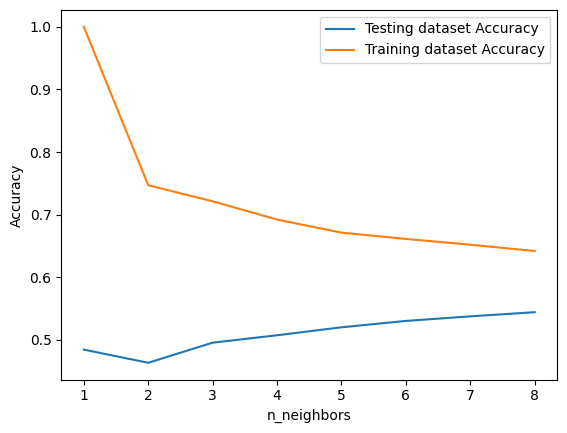

In [234]:
# Generate plot
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
 
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

In [235]:
neighbors = np.arange(1, 9)
train_accuracy_wo_roi = np.empty(len(neighbors))
test_accuracy_wo_roi = np.empty(len(neighbors))

In [236]:
# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(A_train, b_train)
     
    # Compute training and test data accuracy
    train_accuracy_wo_roi[i] = knn.score(A_train, b_train)
    test_accuracy_wo_roi[i] = knn.score(A_test, b_test)

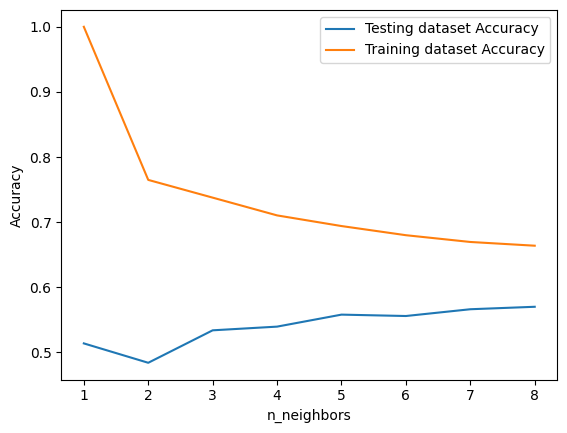

In [237]:
# Generate plot
plt.plot(neighbors, test_accuracy_wo_roi, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy_wo_roi, label = 'Training dataset Accuracy')
 
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

#### *Now finding accuracy and f1 score for both types of data*

In [238]:
knn = KNeighborsClassifier(n_neighbors=9)

In [239]:
nca_pipe = Pipeline([('knn', knn)])

In [240]:
nca_pipe.fit(X_train, y_train)
print(nca_pipe.score(X_test, y_test))

0.5464209780297661


In [241]:
y_pred=nca_pipe.predict(X_test)

[[ 247  150  293    3]
 [ 122  547  506    6]
 [ 183  358 1516    9]
 [  45   78  167    3]]
              precision    recall  f1-score   support

           0       0.41      0.36      0.38       693
           1       0.48      0.46      0.47      1181
           2       0.61      0.73      0.67      2066
           3       0.14      0.01      0.02       293

    accuracy                           0.55      4233
   macro avg       0.41      0.39      0.39      4233
weighted avg       0.51      0.55      0.52      4233



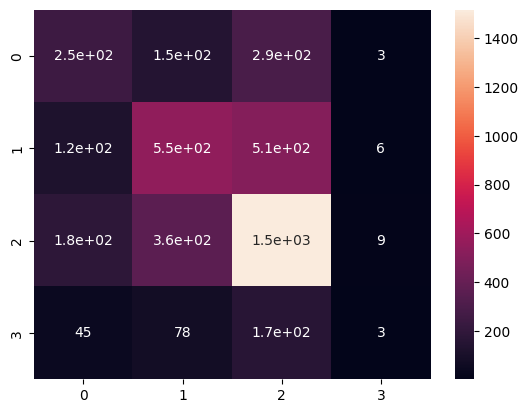

In [242]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

In [243]:
nca_pipe.fit(A_train, b_train)
print(nca_pipe.score(A_test, b_test))

0.5714623198677061


In [244]:
y_pred_1=nca_pipe.predict(A_test)

[[ 354  134  200    5]
 [ 146  501  519   15]
 [ 115  386 1545   20]
 [  45   92  137   19]]
              precision    recall  f1-score   support

           0       0.54      0.51      0.52       693
           1       0.45      0.42      0.44      1181
           2       0.64      0.75      0.69      2066
           3       0.32      0.06      0.11       293

    accuracy                           0.57      4233
   macro avg       0.49      0.44      0.44      4233
weighted avg       0.55      0.57      0.55      4233



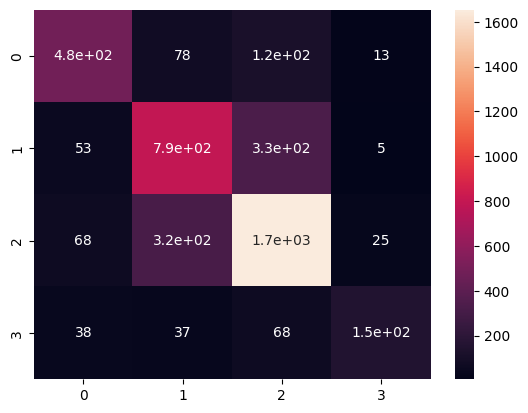

In [245]:
sns.heatmap(confusion_matrix(b_test,y_pred_wo_roi), annot=True)
print(confusion_matrix(b_test,y_pred_1))
print(classification_report(b_test,y_pred_1))

#### **SUMMARY**


1.   **PREPROCESSED IMAGE : Accuracy: 0.54  F1 score : 0.52 (weighted)**
2.   **NON-PREPROCESSED IMAGE : Accuracy: 0.57  F1 score : 0.55(weighted)** 



### **Random Forest**



#### *Importing Random Forest*

In [246]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

#### *Visualising how the accuracy varies with the number of trees in random forest for preproceesed and non- preprocessed images*

In [247]:
d_trees = np.arange(1, 100)

In [248]:
train_accuracy = np.empty(len(d_trees))

In [249]:
for i in (d_trees):
    rfc = RandomForestClassifier(n_estimators=i)
    rfc.fit(X_train, y_train)
     
    # Compute training and test data accuracy
    y_pred = rfc.predict(X_test)
    #metrics.accuracy_score(b_test, y_pred)
    train_accuracy[i-1] = metrics.accuracy_score(y_test, y_pred)

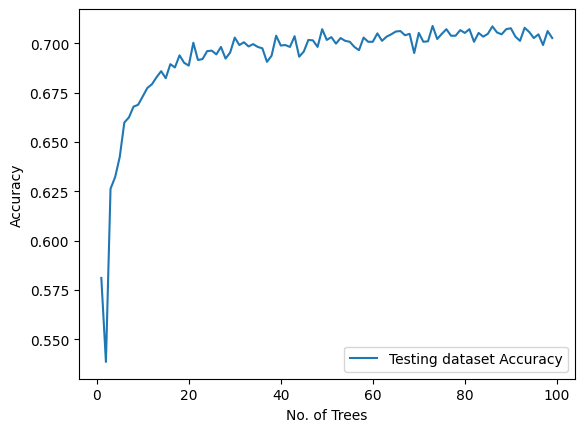

In [250]:
# Generate plot
plt.plot(d_trees,train_accuracy, label = 'Testing dataset Accuracy')

 
plt.legend()
plt.xlabel('No. of Trees')
plt.ylabel('Accuracy')
plt.show()

In [251]:
train_accuracy_wo_roi = np.empty(len(d_trees))

In [252]:
for i in (d_trees):
    rfc = RandomForestClassifier(n_estimators=i)
    rfc.fit(A_train, b_train)
     
    # Compute training and test data accuracy
    y_pred = rfc.predict(A_test)
    #metrics.accuracy_score(b_test, y_pred)
    train_accuracy_wo_roi[i-1] = metrics.accuracy_score(b_test, y_pred)

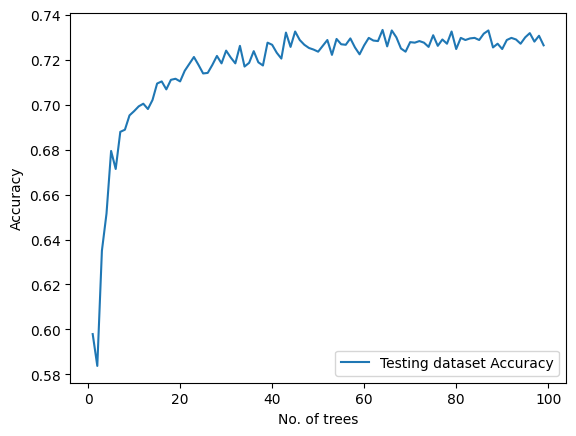

In [253]:
# Generate plot
plt.plot(d_trees,train_accuracy_wo_roi, label = 'Testing dataset Accuracy')
#plt.plot(, train_accuracy, label = 'Training dataset Accuracy')
 
plt.legend()
plt.xlabel('No. of trees')
plt.ylabel('Accuracy')
plt.show()

#### Finding accuracy for both types of data

In [254]:
clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#print(df.feature_names)
#feature_imp = pd.Series(clf.feature_importances_,index=d1.feature_names).sort_values(ascending=False)
#print(feature_imp)

Accuracy: 0.7030474840538625


In [255]:
clf=RandomForestClassifier(n_estimators=100)

clf.fit(A_train,b_train)

y_pred_wo_roi=clf.predict(A_test)

print("Accuracy:",metrics.accuracy_score(b_test, y_pred_wo_roi))

#print(df.feature_names)
#feature_imp = pd.Series(clf.feature_importances_,index=d1.feature_names).sort_values(ascending=False)
#print(feature_imp)

Accuracy: 0.7278525868178597


#### Creating confusion matrix for both the types of data

[[ 368  121  188   16]
 [  68  770  331   12]
 [ 101  215 1723   27]
 [  28   61   89  115]]
              precision    recall  f1-score   support

           0       0.65      0.53      0.59       693
           1       0.66      0.65      0.66      1181
           2       0.74      0.83      0.78      2066
           3       0.68      0.39      0.50       293

    accuracy                           0.70      4233
   macro avg       0.68      0.60      0.63      4233
weighted avg       0.70      0.70      0.70      4233



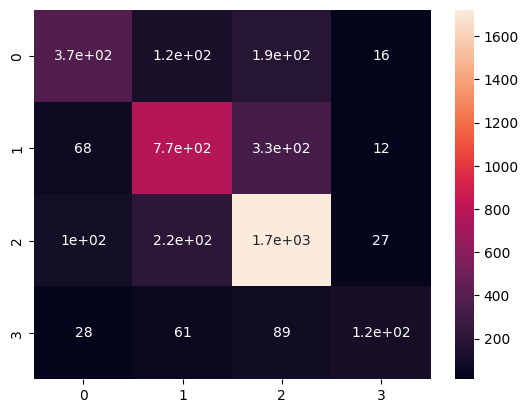

In [256]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 478   84  117   14]
 [  49  788  339    5]
 [  72  306 1667   21]
 [  40   36   69  148]]
              precision    recall  f1-score   support

           0       0.75      0.69      0.72       693
           1       0.65      0.67      0.66      1181
           2       0.76      0.81      0.78      2066
           3       0.79      0.51      0.62       293

    accuracy                           0.73      4233
   macro avg       0.74      0.67      0.69      4233
weighted avg       0.73      0.73      0.73      4233



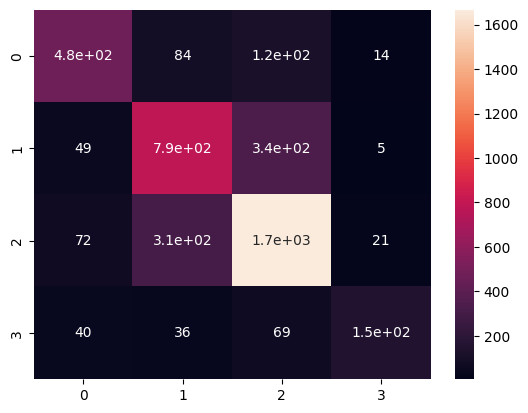

In [257]:
sns.heatmap(confusion_matrix(b_test,y_pred_wo_roi), annot=True)
print(confusion_matrix(b_test,y_pred_wo_roi))
print(classification_report(b_test,y_pred_wo_roi))

#### **SUMMARY**


1.   **PREPROCESSED IMAGE : Accuracy: 0.71  F1 score : 0.69 (weighted)**
2.   **NON-PREPROCESSED IMAGE : Accuracy: 0.73  F1 score : 0.70(weighted)** 


### **SVM**

#### *Importing SVM and training the model and getting accuracy*

In [258]:
from sklearn.svm import SVC
model_1= SVC(kernel='linear').fit(X_train,y_train)
print(model_1.score(X_train,y_train))


0.5982163949917316


In [259]:
y_pred = model_1.predict(X_test)
print(model_1.score(X_test,y_test))

0.5922513583746751


In [260]:
from sklearn.svm import SVC
model_1= SVC(kernel='linear').fit(A_train,b_train)
print(model_1.score(A_train,b_train))

0.589062130876447


In [261]:
y_pred_wo_roi = model_1.predict(A_test)
print(model_1.score(A_test,b_test))

0.5773682967162769


#### *Finding confusion matrix for both the data*

[[  38  181  474    0]
 [  32  696  453    0]
 [  46  247 1773    0]
 [  15   82  196    0]]
              precision    recall  f1-score   support

           0       0.29      0.05      0.09       693
           1       0.58      0.59      0.58      1181
           2       0.61      0.86      0.71      2066
           3       0.00      0.00      0.00       293

    accuracy                           0.59      4233
   macro avg       0.37      0.38      0.35      4233
weighted avg       0.51      0.59      0.53      4233



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


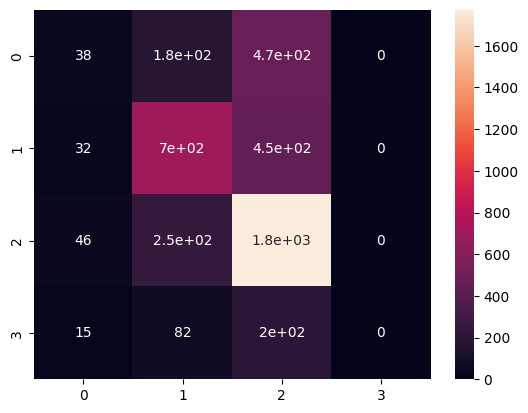

In [262]:

sns.heatmap(confusion_matrix(y_test,y_pred), annot=True)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 112  144  437    0]
 [  17  659  505    0]
 [  40  353 1673    0]
 [  13   38  242    0]]
              precision    recall  f1-score   support

           0       0.62      0.16      0.26       693
           1       0.55      0.56      0.55      1181
           2       0.59      0.81      0.68      2066
           3       0.00      0.00      0.00       293

    accuracy                           0.58      4233
   macro avg       0.44      0.38      0.37      4233
weighted avg       0.54      0.58      0.53      4233



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


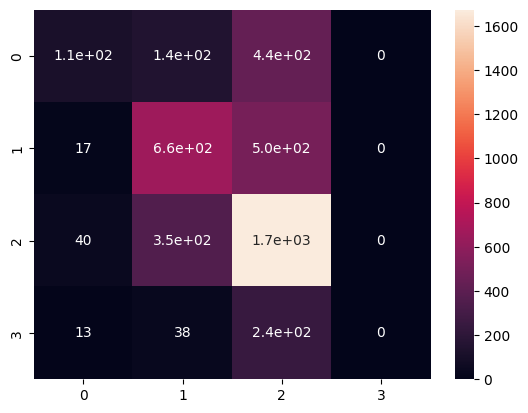

In [263]:
sns.heatmap(confusion_matrix(b_test,y_pred_wo_roi), annot=True)
print(confusion_matrix(b_test,y_pred_wo_roi))
print(classification_report(b_test,y_pred_wo_roi))

#### **SUMMARY**


1.   **PREPROCESSED IMAGE : Accuracy: 0.59  F1 score : 0.53 (weighted)**
2.   **NON-PREPROCESSED IMAGE : Accuracy: 0.58  F1 score : 0.53(weighted)** 

## **CONCLUSION**

Index  | Accuracy  | f1 Score
-------------------|------------------   |------------------
KNN       | 0.54       | 0.52
Random Forest      | 0.71       | 0.69
SVM       | 0.59        | 0.53




